<a href="https://colab.research.google.com/github/MKeel1ng/CELL-GAN/blob/master/wgan_gp_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on: 

# WGAN-GP overriding `Model.train_step`

**Original Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2020/05/9<br>
**Last modified:** 2020/05/9<br>
**Description:** Implementation of Wasserstein GAN with Gradient Penalty.

## Wasserstein GAN (WGAN) with Gradient Penalty (GP)

The original [Wasserstein GAN](https://arxiv.org/abs/1701.07875) leverages
the Wasserstein distance to produce a value function that has better theoretical
properties than the value function used in the original GAN paper. WGAN requires that
the discriminator (aka the critic) lie within the space of 1-Lipschitz functions.
The authors proposed the idea of weight clipping to achieve this constraint. Though
weight clipping works, it can be a problematic way to enforce 1-Lipschitz constraint
and can cause undesirable behavior, e.g. a very deep WGAN discriminator (critic)
often fails to converge.

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf) proposed an alternative to weight
clipping to ensure smooth training. Instead of clipping the weights, the authors
proposed a "gradient penalty": adding a loss term that keeps the L2
norm of the discriminator gradients close to 1.


## Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Prepare Data

Save images as a numpy file at the desired resolution


In [ ]:
IMG_SHAPE = (64, 64, 3)

#Folder where cell images are located
content='/content/drive/My Drive/...'



In [ ]:
#get list of images, token is used to clean up any unwanted images. In my case all cell images begin with 'c', other images in folder are ignored

import os
n = os.listdir(content)
token='c'
clean_names=[name for name in n if name[0]==token]
print(len(clean_names))


5772


##Augment data

Flip the cells about each axis, get's 4x as much data. Images are sclaed 0-1, NOT -1 to 1 (seems to work better for the black background when combined with a leaky ReLU activation as opposed to the traditional *tanh*.

In [ ]:
#ims=np.zeros((len(clean_names)*4, 128, 128, 3)).astype('float32')
count=0
import cv2

resolution=IMG_SHAPE[0]
for i,im in enumerate(clean_names):
  
  im=cv2.imread(content+im)/255
  im=cv2.resize(im,(resolution,resolution))
  ims[count,:,:,:]=im
  count+=1

  ims[count,:,:,:]=cv2.flip(im, -1)
  count+=1

  ims[count,:,:,:]=cv2.flip(im, 1)
  count+=1

  ims[count,:,:,:]=cv2.flip(im, 0)
  count+=1

  #keep track of progress
  print(count/(len(clean_names)*4)*100)

np.save(content+'ims_'+str(resolution)+'x,ims)

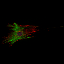

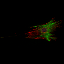

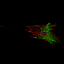

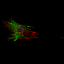

(23088, 64, 64, 3)


In [ ]:
#check data

from google.colab.patches import cv2_imshow

train_images=np.load(content+'ims_64x.npy')
cv2_imshow(train_images[0,:,:,:]*255)
cv2_imshow(train_images[1,:,:,:]*255)
cv2_imshow(train_images[2,:,:,:]*255)
cv2_imshow(train_images[3,:,:,:]*255)
print(train_images.shape)

##Set up model

**1: SELF ATTENTION lAYER**

In [ ]:
from keras import backend as K
from keras.engine.topology import Layer

class Attention(Layer):
    def __init__(self, ch, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_f_g = self.channels // 8
        self.filters_h = self.channels

    def build(self, input_shape):
        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        print(kernel_shape_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        self.kernel_f = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_f')
        self.kernel_g = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_g')
        self.kernel_h = self.add_weight(shape=kernel_shape_h,
                                        initializer='glorot_uniform',
                                        name='kernel_h')
        self.bias_f = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_F')
        self.bias_g = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_g')
        self.bias_h = self.add_weight(shape=(self.filters_h,),
                                      initializer='zeros',
                                      name='bias_h')
        super(Attention, self).build(input_shape)
        # Set input spec.
        self.input_spec = tf.keras.layers.InputSpec(ndim=4,
                                    axes={3: input_shape[-1]})
        self.built = True


    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[-1]])

        f = K.conv2d(x,
                     kernel=self.kernel_f,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        f = K.bias_add(f, self.bias_f)
        g = K.conv2d(x,
                     kernel=self.kernel_g,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        g = K.bias_add(g, self.bias_g)
        h = K.conv2d(x,
                     kernel=self.kernel_h,
                     strides=(1, 1), padding='same')  # [bs, h, w, c]
        h = K.bias_add(h, self.bias_h)

        s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)  # # [bs, N, N]

        beta = K.softmax(s, axis=-1)  # attention map

        o = K.batch_dot(beta, hw_flatten(h))  # [bs, N, C]

        o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x

        return x

    def compute_output_shape(self, input_shape):
        return input_shape

## Create the discriminator (aka critic in the original WGAN)



In [ ]:
from keras.regularizers import l2
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.2,
):
    x = layers.Conv2D(filters, kernel_size, strides=(2,2), kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(filters, kernel_size, strides=(1,1), kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(drop_value)(x)
    
    return x

#SA1=Attention(256)
SA2=Attention(64)
def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    x = layers.Conv2D(64, (3,3), strides=(1,1), kernel_regularizer=l2(0.1), padding="same",  use_bias=True)(img_input)
    
    x = layers.LeakyReLU(0.2)(x)
    # Zero pad the input to make the input images size to (32, 32, 1).
    #x = layers.ZeroPadding2D((0, 0))()
    x = conv_block(
        x,
        64,
        kernel_size=(3, 3),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        
    )
    x=SA2(x)
    x = conv_block(
        x,
        128,
        kernel_size=(3, 3),
        strides=(1, 1),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
       

    x = conv_block(
        x,
        256,
        kernel_size=(3, 3),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )

    #x=SA1(x)

    x = conv_block(
        x,
        512,
        kernel_size=(3, 3),
        strides=(1, 1),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )





    x = layers.Conv2D(1, kernel_size=(4,4), strides=(1,1))(x)
    #x = layers.Flatten()(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model

#INSPECT MODEL
d_model = get_discriminator_model()
d_model.summary()
tf.keras.utils.plot_model(d_model)


(1, 1, 64, 8)
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 32,

## Create the generator


In [ ]:

def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    #x = layers.Conv2DTranspose(filters, kernel_size,strides=(2,2),kernel_regularizer=l2(0.001), padding=padding, use_bias=use_bias)(x)
    x = layers.UpSampling2D(up_size,interpolation='bilinear')(x)
    x = layers.Conv2D(filters, kernel_size ,strides=(1,1),kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(filters, kernel_size ,strides=(1,1),kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)


    return x

def upsample_block_final(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.Conv2D(filters, kernel_size,strides=(1,1), kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(filters, kernel_size,strides=(1,1), kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(3, kernel_size ,strides=(1,1), padding=padding, kernel_regularizer=l2(0.1),use_bias=use_bias)(x)
    #x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    return x

SA1=Attention(128)
#SA2=Attention(512)

def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        512,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    #x=SA2(x)
    x = upsample_block(
        x,
        256,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )

    
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x=SA1(x)
    
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,


    )


    x = upsample_block_final(
        x, 32, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    #x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()
tf.keras.utils.plot_model(g_model)

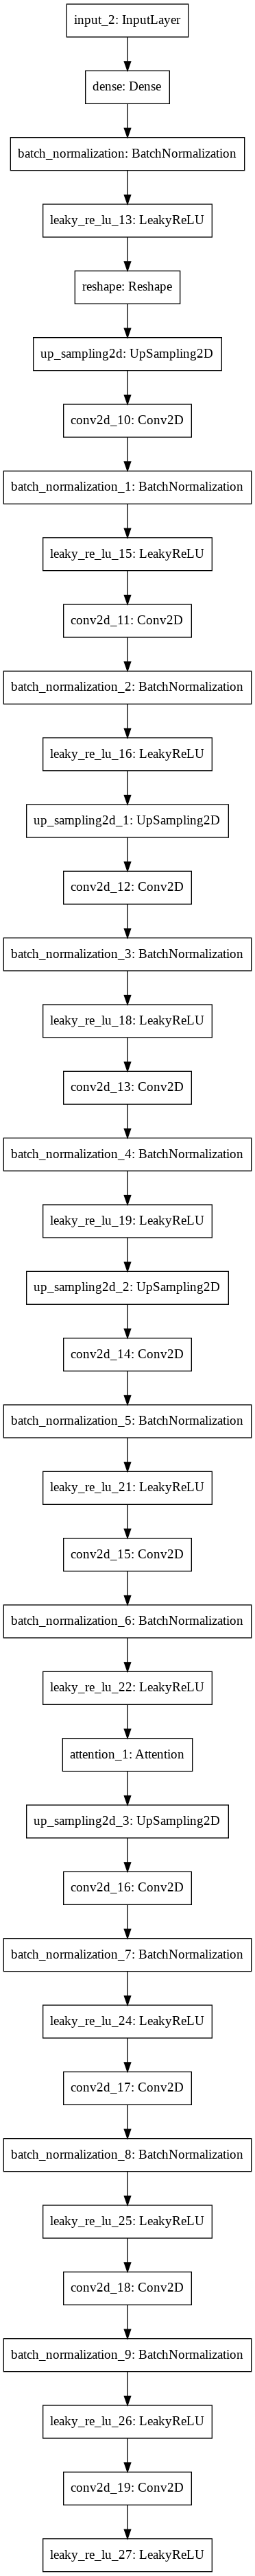

## Create a WGAN-GP model 
Now that we have defined our generator and discriminator models, we will
implement the WGAN-GP model. We will override the `train_step` for training.


In [ ]:

class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper.
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add gradient penalty to the discriminator loss
        # 6. Return generator and discriminator losses as a loss dictionary.

        # Train discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate discriminator loss using fake and real logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator now.
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}



## Create a callback that periodically saves generated images

Makes a 5 by 5 tiled grid. By feeding it the same noise you see the evolution of the model on the same images

In [ ]:
from google.colab.patches import cv2_imshow
from PIL import Image


def concat_tile(im_list_2d):
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img, random_latent_vectors):
        self.num_img = num_img
        self.random_latent_vectors = random_latent_vectors

    def on_epoch_end(self, epoch, logs=None):
        #random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(self.random_latent_vectors)
        generated_images = (generated_images * 255)
        

        ims=[]
        for i in range(self.num_img):
            img = generated_images[i].numpy()
            #img=append(np.array(keras.preprocessing.image.array_to_img(img)))
            #img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))
            ims.append(np.array(keras.preprocessing.image.array_to_img(img)))
        
        ims_tiled=concat_tile([[ims[0],ims[1],ims[2],ims[3],ims[4]],
                               [ims[5],ims[6],ims[7],ims[8],ims[9]],
                               [ims[10],ims[11],ims[12],ims[13],ims[14]],
                               [ims[15],ims[16],ims[17],ims[18],ims[19]],
                               [ims[20],ims[21],ims[22],ims[23],ims[24]]])
        im = Image.fromarray(ims_tiled)
        im.save('/content/drive/My Drive/..../'+'generated_img_{epoch}.png'.format(epoch=epoch))
        cv2_imshow(ims_tiled)



## Train the end-to-end model


In [ ]:
import cv2

# Optimizer for both the networks
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions to be used for generator
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

#Models
d_model = get_discriminator_model()
g_model = get_generator_model()

# Training details
epochs = 100
BATCH_SIZE = 256
noise_dim = 256

# Callbacks
num_val_ims=25
random_latent_vectors = tf.random.normal((num_val_ims,noise_dim))
image_callback = GANMonitor(num_img=num_val_ims,random_latent_vectors=random_latent_vectors)
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=content+'.../model')

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)


# Start training
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[image_callback,checkpoint_callback])


##Generate New Images

Load model

In [ ]:
wgan.load_weights(content+'.../model')


Visualise batch of generated images

In [ ]:
num_val_ims=25
random_latent_vectors = tf.random.normal((num_val_ims,noise_dim))
ans=wgan.generator(random_latent_vectors)


ims=np.array(ans)*255
#yes, tiling like this is ugly
ims_tiled=concat_tile([[ims[0],ims[1],ims[2],ims[3],ims[4]],
                        [ims[5],ims[6],ims[7],ims[8],ims[9]],
                        [ims[10],ims[11],ims[12],ims[13],ims[14]],
                        [ims[15],ims[16],ims[17],ims[18],ims[19]],
                        [ims[20],ims[21],ims[22],ims[23],ims[24]]])
#Visualise data
cv2_imshow(ims_tiled)

Save Some images

In [ ]:
num_ims_to_save=100

num_val_ims=num_ims_to_save
random_latent_vectors = tf.random.normal((num_val_ims,noise_dim))
ans=wgan.generator(random_latent_vectors)


ims=np.array(ans)*255

for i,frame in enumerate(ims):
  #im = Image.fromarray(frame)

  cv2_imshow(frame)
  cv2.imwrite('/content/drive/My Drive/ThesisDL/CELL_GAN/MF_CELLS/model_old_wd_gen/'+'generated_img_{i}.png'.format(i=i),frame)

